**Here I will try to implement ResNet 50 on the 102 Flowers dataset. I begin with loading the data. Then  I train and evaluate the performance of ResNet 50 on the loaded data.**

In [1]:
# Downloading the main data files
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar -xzf 102flowers.tgz
!rm 102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2023-10-04 21:52:49--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2023-10-04 21:52:49--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2023-10-04 21:52:50--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting respo

In [2]:
# Importing Needed Libraries
import tarfile as tf
import os
import numpy as np
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy.io import loadmat
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from keras.utils import to_categorical
from collections import Counter

print ('Import Completed')

def set_device(): # Function to help with determining the accelerator
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  if device == 'cuda':
    print('GPU yay!')
  elif device == 'cpu':
    print('CPU :|')
  return device
DEVICE = set_device()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Import Completed
GPU yay!


In [3]:
# Load the images from the folder into a python list, as numpy arrays
image_folder = "/kaggle/working/jpg"
all_imgs = list()
all_labels = []
for img_name in tqdm(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, img_name)
    img = Image.open(image_path)
    img_array = np.array(img)
    all_imgs.append(img_array)
    all_labels.append(int(img_name[6:11])-1)
    # see whether there are any images with different shapes or dimensions in the dataset
    if len(img_array.shape) != 3 or img_array.shape[2] != 3:
        print('Differing dimension/shape detected!')

print(f"Number of total images is: {len(all_imgs)}")

100%|██████████| 8189/8189 [00:24<00:00, 331.11it/s]

Number of total images is: 8189


In [4]:
# Load the Labels as Mat objects and explore them
img_labels = loadmat("imagelabels.mat")
print(img_labels.keys())
img_labels = img_labels['labels'][0]
print(f"Number of total labels is: {len(img_labels)}")

# convert the indices in all_labels list to the actual label of their corresponding image
all_labels = [img_labels[i] - 1 for i in all_labels] # Since the to_categorical function expects values to start from 0,
print(f"Range of labels: {min(all_labels)} - {max(all_labels)}") # I subtract 1 from all label values.

# convert numbers to
all_labels = to_categorical(all_labels, num_classes = 102, dtype = float)

print(f"Number of classes: {all_labels.shape[1]}")

# To make sure there are enough examples for each of the labels, Let's check the min and max occurences.
label_counts = Counter(img_labels)
print(f"Most repeated label is {label_counts.most_common()[0][0]}: {label_counts.most_common()[0][1]} times")
print(f"Least repeated label is {label_counts.most_common()[-1][0]}: {label_counts.most_common()[-1][1]} times")

dict_keys(['__header__', '__version__', '__globals__', 'labels'])
Number of total labels is: 8189
Range of labels: 0 - 101
Number of classes: 102
Most repeated label is 51: 258 times
Least repeated label is 7: 40 times


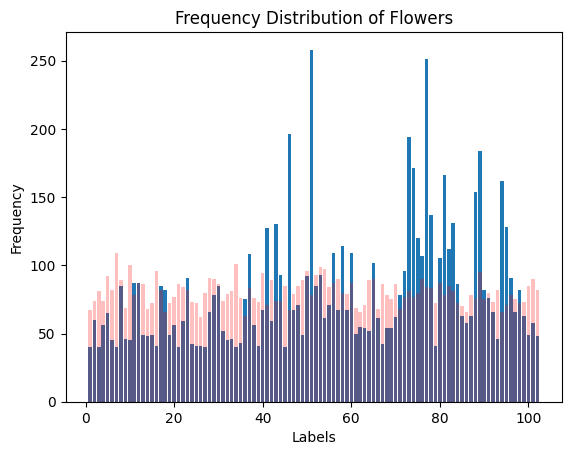

In [5]:
# And now let's visualize the distribution of frequencies:
values = label_counts.keys()
counts = label_counts.values()
plt.bar(values, counts)
# Generate a uniform distribution to visually compare with our data
num_samples = len(img_labels)
min_value = min(img_labels)
max_value = max(img_labels)
uniform_data = np.random.randint(min_value, max_value + 1, num_samples) # create a uniform distribution within the same range

# Count the occurrences of each value in the uniform distribution
uniform_value_counts = Counter(uniform_data)

# Extract values and counts for plotting
uniform_values = list(uniform_value_counts.keys())
uniform_counts = list(uniform_value_counts.values())
# Create the bar chart
plt.bar(uniform_values, uniform_counts, alpha=0.25, color='red', label='Uniform Distribution')

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Flowers')
plt.show()

In [6]:
# Here I split the data into train, validation, and test sets.
trainx, testx, trainy, testy = tts(all_imgs, all_labels, test_size = 0.2, random_state = 7)
valx, testx, valy, testy = tts(testx, testy, test_size = 0.5, random_state = 7)
# Create datasets corresponding to train, valid, and test data, to load them later on via dataloaders to the neural network.
class data_set(Dataset):
    def __init__(self, img, label, transform = None):
        self.img = img
        self.label = label
        self.transform = transform
    def __getitem__(self, idx):
        img = self.img[idx]
        label = self.label[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.label)
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((112, 112), interpolation=Image.BILINEAR, antialias = None)
])

batch_size = 128 # This batch size seems to work well with my resources!
train_set = data_set(trainx, trainy, transform = transform)
val_set = data_set(valx, valy, transform = transform)
test_set = data_set(testx, testy, transform = transform)

train_loader = DataLoader(train_set, batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size, shuffle = False)
test_loader = DataLoader(test_set, batch_size, shuffle = False)

In [7]:
# Now Let's load the ResNet 50 and intiialize its hyperparamteres.

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # set the model to be loaded as pretrained
for param in resnet.parameters(): # I freeze the weights to only train the classifier layer (here it is frozen),
    param.requires_grad = False     # while keeping the model's feature extraction capability


# And next I modify the final later to output the same number of categories in the dataset.
resnet.fc = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 102),
            nn.Softmax(dim = 1)  # Add a softmax activation to produce class probabilities.
            )

resnet.to(DEVICE) # Hopefully Cuda!
print('Resnet 50 Loaded!')

# And here I set the loss function to cross entropy loss since I want to multi-class classification
loss_f = nn.CrossEntropyLoss()
epochs = 25

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Resnet 50 Loaded!


In [8]:
# Now I can train the pretrained Model on train set.
# Also I assign some variables to measure the model's performance while training.
train_losses = list()
train_accuracies = list()
val_losses = list()
val_accuracies = list()

for epoch in tqdm(range(epochs)): 
    lr = 2e-3 * 0.99 ** (epoch-1) # use learning rate decay
    optimizer = optim.Adam(resnet.parameters(), lr = lr) # Use Adam optimizer for faster gradient decent steps
    resnet.train() # training mode on

    running_loss = 0.0
    num_samples = 0
    num_correct = 0
    for img, label in train_loader:
        img, label = img.to(DEVICE), label.to(DEVICE) # move all variable to GPU before feeding to network
        optimizer.zero_grad() # do the training loop and update model parameters (FC layer only)
        output = resnet(img)
        loss = loss_f(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)  # Get the class with the highest probability
        _, true_label = torch.max(label, 1)
        num_samples += label.size(0)
        num_correct += (predicted == true_label).sum().item()
        
    train_accuracy = 100 * num_correct / num_samples
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        vr_loss = 0
        val_samples = 0
        val_corrects = 0
        for img, label in val_loader:
            img, label = img.to(DEVICE), label.to(DEVICE)
            output = resnet(img)
            _, predicted = torch.max(output, 1)
            _, true_label = torch.max(label, 1)
            
            val_samples += label.size(0)
            val_corrects += (predicted == true_label).sum().item()
            vr_loss += loss_f(output, label).item()
        val_accuracy = 100 * val_corrects/val_samples
        val_loss = vr_loss/len(val_loader)
        print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {epoch_loss:.4f} - Training Accuracy: {train_accuracy:.2f}%")
        print(f"Epoch [{epoch + 1}/{epochs}] - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%")
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

  4%|▍         | 1/25 [00:28<11:25, 28.56s/it]

Epoch [1/25] - Training Loss: 4.4962 - Training Accuracy: 23.46%
Epoch [1/25] - Validation Loss: 4.3516 - Validation Accuracy: 43.47%


  8%|▊         | 2/25 [00:52<09:51, 25.71s/it]

Epoch [2/25] - Training Loss: 4.2095 - Training Accuracy: 55.87%
Epoch [2/25] - Validation Loss: 4.1737 - Validation Accuracy: 61.66%


 12%|█▏        | 3/25 [01:15<09:03, 24.71s/it]

Epoch [3/25] - Training Loss: 4.0431 - Training Accuracy: 70.75%
Epoch [3/25] - Validation Loss: 4.0907 - Validation Accuracy: 67.03%


 16%|█▌        | 4/25 [01:38<08:26, 24.11s/it]

Epoch [4/25] - Training Loss: 3.9420 - Training Accuracy: 78.61%
Epoch [4/25] - Validation Loss: 4.0423 - Validation Accuracy: 71.55%


 20%|██        | 5/25 [02:02<07:58, 23.93s/it]

Epoch [5/25] - Training Loss: 3.8798 - Training Accuracy: 83.15%
Epoch [5/25] - Validation Loss: 3.9970 - Validation Accuracy: 73.26%


 24%|██▍       | 6/25 [02:25<07:30, 23.70s/it]

Epoch [6/25] - Training Loss: 3.8327 - Training Accuracy: 86.05%
Epoch [6/25] - Validation Loss: 3.9740 - Validation Accuracy: 74.36%


 28%|██▊       | 7/25 [02:49<07:05, 23.66s/it]

Epoch [7/25] - Training Loss: 3.8047 - Training Accuracy: 88.23%
Epoch [7/25] - Validation Loss: 3.9586 - Validation Accuracy: 75.34%


 32%|███▏      | 8/25 [03:12<06:37, 23.41s/it]

Epoch [8/25] - Training Loss: 3.7759 - Training Accuracy: 89.86%
Epoch [8/25] - Validation Loss: 3.9391 - Validation Accuracy: 76.19%


 36%|███▌      | 9/25 [03:35<06:14, 23.44s/it]

Epoch [9/25] - Training Loss: 3.7501 - Training Accuracy: 92.20%
Epoch [9/25] - Validation Loss: 3.9267 - Validation Accuracy: 76.92%


 40%|████      | 10/25 [03:59<05:52, 23.49s/it]

Epoch [10/25] - Training Loss: 3.7295 - Training Accuracy: 93.50%
Epoch [10/25] - Validation Loss: 3.9164 - Validation Accuracy: 78.27%


 44%|████▍     | 11/25 [04:23<05:29, 23.53s/it]

Epoch [11/25] - Training Loss: 3.7181 - Training Accuracy: 94.41%
Epoch [11/25] - Validation Loss: 3.9080 - Validation Accuracy: 77.78%


 48%|████▊     | 12/25 [04:46<05:04, 23.42s/it]

Epoch [12/25] - Training Loss: 3.7114 - Training Accuracy: 95.02%
Epoch [12/25] - Validation Loss: 3.9003 - Validation Accuracy: 78.63%


 52%|█████▏    | 13/25 [05:09<04:40, 23.40s/it]

Epoch [13/25] - Training Loss: 3.6998 - Training Accuracy: 95.51%
Epoch [13/25] - Validation Loss: 3.8952 - Validation Accuracy: 78.51%


 56%|█████▌    | 14/25 [05:32<04:17, 23.39s/it]

Epoch [14/25] - Training Loss: 3.6982 - Training Accuracy: 95.85%
Epoch [14/25] - Validation Loss: 3.8915 - Validation Accuracy: 79.24%


 60%|██████    | 15/25 [05:56<03:55, 23.53s/it]

Epoch [15/25] - Training Loss: 3.6882 - Training Accuracy: 96.50%
Epoch [15/25] - Validation Loss: 3.8857 - Validation Accuracy: 79.00%


 64%|██████▍   | 16/25 [06:19<03:30, 23.37s/it]

Epoch [16/25] - Training Loss: 3.6799 - Training Accuracy: 97.10%
Epoch [16/25] - Validation Loss: 3.8832 - Validation Accuracy: 79.37%


 68%|██████▊   | 17/25 [06:43<03:07, 23.50s/it]

Epoch [17/25] - Training Loss: 3.6768 - Training Accuracy: 97.40%
Epoch [17/25] - Validation Loss: 3.8771 - Validation Accuracy: 80.46%


 72%|███████▏  | 18/25 [07:07<02:44, 23.56s/it]

Epoch [18/25] - Training Loss: 3.6727 - Training Accuracy: 97.65%
Epoch [18/25] - Validation Loss: 3.8752 - Validation Accuracy: 80.46%


 76%|███████▌  | 19/25 [07:30<02:20, 23.42s/it]

Epoch [19/25] - Training Loss: 3.6693 - Training Accuracy: 98.02%
Epoch [19/25] - Validation Loss: 3.8717 - Validation Accuracy: 79.98%


 80%|████████  | 20/25 [07:53<01:57, 23.48s/it]

Epoch [20/25] - Training Loss: 3.6651 - Training Accuracy: 98.21%
Epoch [20/25] - Validation Loss: 3.8687 - Validation Accuracy: 80.71%


 84%|████████▍ | 21/25 [08:17<01:34, 23.52s/it]

Epoch [21/25] - Training Loss: 3.6636 - Training Accuracy: 98.44%
Epoch [21/25] - Validation Loss: 3.8636 - Validation Accuracy: 79.98%


 88%|████████▊ | 22/25 [08:41<01:10, 23.65s/it]

Epoch [22/25] - Training Loss: 3.6633 - Training Accuracy: 98.49%
Epoch [22/25] - Validation Loss: 3.8602 - Validation Accuracy: 80.71%


 92%|█████████▏| 23/25 [09:04<00:47, 23.54s/it]

Epoch [23/25] - Training Loss: 3.6593 - Training Accuracy: 98.70%
Epoch [23/25] - Validation Loss: 3.8644 - Validation Accuracy: 80.34%


 96%|█████████▌| 24/25 [09:28<00:23, 23.56s/it]

Epoch [24/25] - Training Loss: 3.6584 - Training Accuracy: 98.78%
Epoch [24/25] - Validation Loss: 3.8596 - Validation Accuracy: 80.46%


100%|██████████| 25/25 [09:52<00:00, 23.68s/it]

Epoch [25/25] - Training Loss: 3.6559 - Training Accuracy: 98.84%
Epoch [25/25] - Validation Loss: 3.8564 - Validation Accuracy: 80.59%


In [9]:
# Now the final step: test the model
num_sample = 0
num_correct = 0
preds = []
true_labels = []
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(DEVICE), label.to(DEVICE)
        output = resnet(img) 
        _, predicted = torch.max(output, 1)
        _, true_label = torch.max(label, 1)
        preds += predicted.cpu().numpy().tolist()
        true_labels += true_label.cpu().numpy().tolist()
        num_sample += label.size(0)
        num_correct += (predicted == true_label).sum().item()
    test_accuracy = 100 * num_correct/num_sample
    print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 80.83%


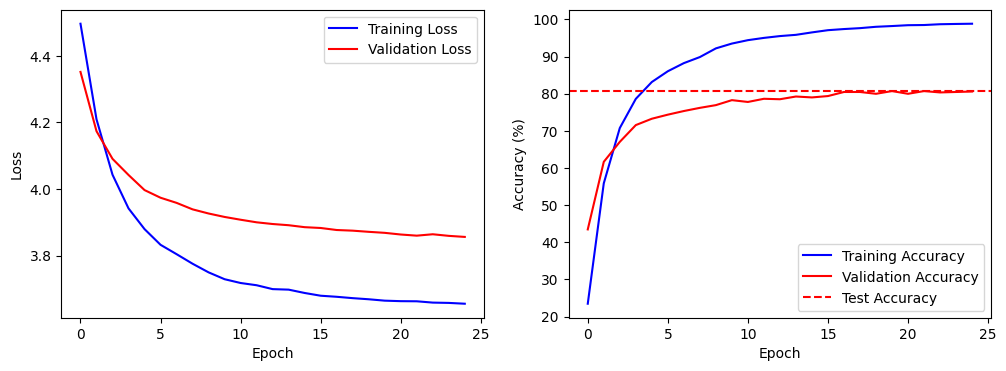

In [10]:
# And visualize the performance
# plot train loss by epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color = 'blue')
plt.plot(val_losses, label='Validation Loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss_plot.png')

# plot training and test accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color = 'blue')
plt.plot(val_accuracies, label='Validation Accuracy', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.legend()
plt.savefig('Acc_plot.png')

plt.show()

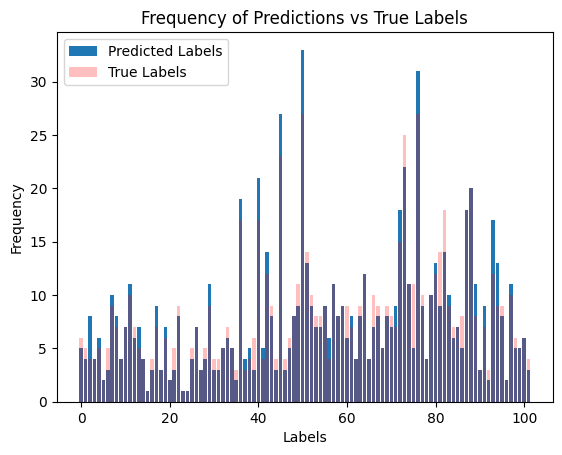

In [11]:
pred_count = Counter(preds)
true_count = Counter(true_labels)
# And now let's visualize the distribution of frequencies:
p_values = pred_count.keys()
p_counts = pred_count.values()
plt.bar(p_values, p_counts, label = 'Predicted Labels')

t_values = list(true_count.keys())
t_counts = list(true_count.values())
# Create the bar chart
plt.bar(t_values, t_counts, alpha=0.25, color='red', label='True Labels')

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Predictions vs True Labels')
plt.legend()
plt.savefig('pred_vs_true_plot.png')
plt.show()